(mccall)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Job Search I: The McCall Search Model

```{contents} Contents
:depth: 2
```

```{epigraph}
"Questioning a McCall worker is like having a conversation with an out-of-work friend:
'Maybe you are setting your sights too high', or 'Why did you quit your old job before you
had a new one lined up?' This is real social science: an attempt to model, to understand,
human behavior by visualizing the situation people find themselves in, the options they face
and the pros and cons as they themselves see them." -- Robert E. Lucas, Jr.
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

## Overview

The McCall search model {cite}`McCall1970` helped transform economists' way of thinking about labor markets.

To clarify  notions such as "involuntary" unemployment, McCall modeled the decision problem of an unemployed worker  in terms of factors including

* current and likely future wages
* impatience
* unemployment compensation

To solve the decision problem McCall used dynamic programming.

Here we set up McCall's model and use dynamic programming to analyze it.

As we'll see, McCall's model is not only interesting in its own right but also an excellent vehicle for learning dynamic programming.

Let's start with some imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import jit, float64
from numba.experimental import jitclass
import quantecon as qe
from quantecon.distributions import BetaBinomial

## The McCall Model

```{index} single: Models; McCall
```

An unemployed agent receives in each period a job offer at wage $w_t$.

In this lecture, we adopt the following simple environment:

* The offer sequence $\{w_t\}_{t \geq 0}$ is IID, with $q(w)$ being the probability of observing wage $w$ in finite set $\mathbb{W}$.
* The agent observes $w_t$ at the start of $t$.
* The agent knows that $\{w_t\}$ is IID with common distribution $q$ and can use this when computing expectations.

(In later lectures, we will relax these assumptions.)

At time $t$, our agent has two choices:

1. Accept the offer and work permanently at constant wage $w_t$.
1. Reject the offer, receive unemployment compensation $c$, and reconsider next period.

The agent is infinitely lived and aims to maximize the expected discounted
sum of earnings

$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t
$$

The constant $\beta$ lies in $(0, 1)$ and is called a **discount factor**.

The smaller is $\beta$, the more the agent discounts future utility relative to current utility.

The variable  $y_t$ is income, equal to

* his/her wage $w_t$ when employed
* unemployment compensation $c$ when unemployed


### A Trade-Off

The worker faces a trade-off:

* Waiting too long for a good offer is costly, since the future is discounted.
* Accepting too early is costly, since better offers might arrive in the future.

To decide optimally in the face of this trade-off, we use dynamic programming.

Dynamic programming can be thought of as a two-step procedure that

1. first assigns values to "states" and
1. then deduces optimal actions given those values

We'll go through these steps in turn.

### The Value Function

In order to optimally trade-off current and future rewards, we need to think about two things:

1. the current payoffs we get from different choices
1. the different states that those choices will lead to in next period 

To weigh these two aspects of the decision problem, we need to assign *values*
to states.

To this end, let $v^*(w)$ be the total lifetime *value* accruing to an
unemployed worker who enters the current period unemployed when the wage is
$w \in \mathbb{W}$.

In particular, the agent has wage offer $w$ in hand.

More precisely, $v^*(w)$ denotes the value of the objective function
{eq}`objective` when an agent in this situation makes *optimal* decisions now
and at all future points in time.

Of course $v^*(w)$ is not trivial to calculate because we don't yet know
what decisions are optimal and what aren't!

But think of $v^*$ as a function that assigns to each possible wage
$s$ the maximal lifetime value that can be obtained with that offer in
hand.

A crucial observation is that this function $v^*$ must satisfy the
recursion

```{math}
:label: odu_pv

v^*(w)
= \max \left\{
        \frac{w}{1 - \beta}, \, c + \beta
        \sum_{w' \in \mathbb{W}} v^*(w') q (w')
    \right\}
```

for every possible $w$  in $\mathbb{W}$.

This important equation is a version of the **Bellman equation**, which is
ubiquitous in economic dynamics and other fields involving planning over time.

The intuition behind it is as follows:

* the first term inside the max operation is the lifetime payoff from accepting current offer, since

$$
    \frac{w}{1 - \beta} = w + \beta w + \beta^2 w + \cdots
$$

* the second term inside the max operation is the **continuation value**, which is the lifetime payoff from rejecting the current offer and then behaving optimally in all subsequent periods

If we optimize and pick the best of these two options, we obtain maximal lifetime value from today, given current offer $w$.

But this is precisely $v^*(w)$, which is the left-hand side of {eq}`odu_pv`.


### The Optimal Policy

Suppose for now that we are able to solve {eq}`odu_pv` for the unknown function $v^*$.

Once we have this function in hand we can behave optimally (i.e., make the
right choice between accept and reject).

All we have to do is select the maximal choice on the right-hand side of {eq}`odu_pv`.

The optimal action is best thought of as a **policy**, which is, in general, a map from
states to actions.

Given *any* $w$, we can read off the corresponding best choice (accept or
reject) by picking the max on the right-hand side of {eq}`odu_pv`.

Thus, we have a map from $\mathbb R$ to $\{0, 1\}$, with 1 meaning accept and 0 meaning reject.

We can write the policy as follows

$$
\sigma(w) := \mathbf{1}
    \left\{
        \frac{w}{1 - \beta} \geq c + \beta \sum_{w' \in \mathbb W}
        v^*(w') q (w')
    \right\}
$$

Here $\mathbf{1}\{ P \} = 1$ if statement $P$ is true and equals 0 otherwise.

We can also write this as

$$
    \sigma(w) := \mathbf{1} \{ w \geq \bar w \}
$$

where

```{math}
:label: reswage

    \bar w := (1 - \beta) \left\{ c + \beta \sum_{w'} v^*(w') q (w') \right\}
```

Here $\bar w$ (called the *reservation wage*) is a constant depending on 
$\beta, c$ and the wage distribution.

The agent should accept if and only if the current wage offer exceeds the reservation wage.

In view of {eq}`reswage`, we can compute this reservation wage if we can compute the value function.


## Computing the Optimal Policy: Take 1

To put the above ideas into action, we need to compute the value function at
each possible state $w \in \mathbb W$.

To simplify notation, let's set 

$$  
\mathbb W := \{w_1, \ldots, w_n  \}
    \quad \text{and} \quad
    v^*(i) := v^*(w_i)
$$

The value function is then represented by the vector 
$v^* = (v^*(i))_{i=1}^n$.

In view of {eq}`odu_pv`, this vector satisfies the nonlinear system of equations

```{math}
:label: odu_pv2

v^*(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v^*(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n
```



### The Algorithm

To compute this vector, we use successive approximations:

Step 1: pick an arbitrary initial guess $v \in \mathbb R^n$.

Step 2: compute a new vector $v' \in \mathbb R^n$ via

```{math}
:label: odu_pv2p

v'(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n
```

Step 3: calculate a measure of a discrepancy between $v$ and $v'$, such as $\max_i |v(i)- v'(i)|$.

Step 4: if the deviation is larger than some fixed tolerance, set $v = v'$ and go to step 2, else continue.

Step 5: return $v$.

For a small tolerance, the returned function $v$ is a close approximation to the value function $v^*$.

The theory below elaborates on this point.

### Fixed Point Theory

What's the mathematics behind these ideas?

First, one defines a mapping $T$ from $\mathbb R^n$ to
itself via

```{math}
:label: odu_pv3

(Tv)(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n
```

(A new vector $Tv$ is obtained from given vector $v$ by evaluating
the r.h.s. at each $i$.)

The element $v_k$ in the sequence $\{v_k\}$ of successive
approximations corresponds to $T^k v$.

* This is $T$ applied $k$ times, starting at the initial guess
  $v$

One can show that the conditions of the [Banach fixed point theorem](https://en.wikipedia.org/wiki/Banach_fixed-point_theorem) are
satisfied by $T$ on $\mathbb R^n$.

One implication is that $T$ has a unique fixed point in $\mathbb R^n$.

* That is, a unique vector $\bar v$ such that $T \bar v = \bar v$.

Moreover, it's immediate from the definition of $T$ that this fixed
point is $v^*$.

A second implication of the  Banach contraction mapping theorem is that
$\{ T^k v \}$ converges to the fixed point $v^*$ regardless of
$v$.

### Implementation

Our default for $q$, the distribution of the state process, will be
[Beta-binomial](https://en.wikipedia.org/wiki/Beta-binomial_distribution).

In [3]:
n, a, b = 50, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

Our default set of values for wages will be

In [4]:
w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

Here's a plot of the probabilities of different wage outcomes:

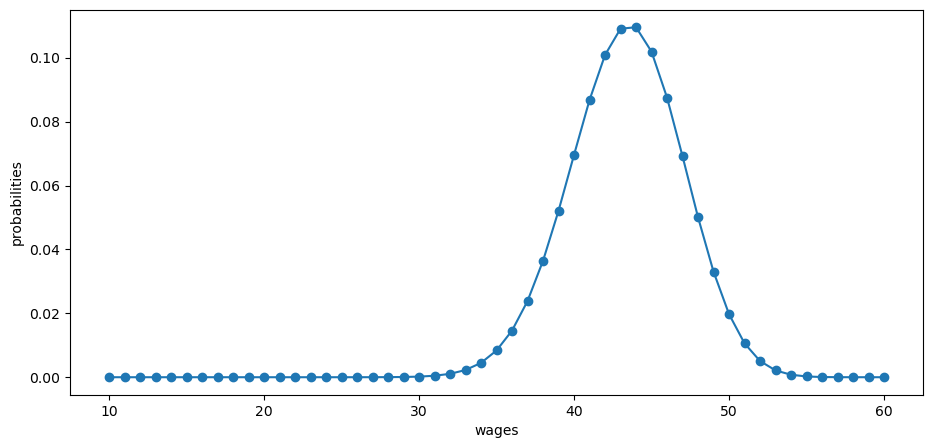

In [5]:
fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

We are going to use Numba to accelerate our code.

* See, in particular, the discussion of `@jitclass` in [our lecture on Numba](https://python-programming.quantecon.org/numba.html).

The following helps Numba by providing some type

In [6]:
mccall_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[:]),   # array of wage values, w[i] = wage at state i
    ('q', float64[:])    # array of probabilities
]

Here's a class that stores the data and computes the values of state-action pairs,
i.e. the value in the maximum bracket on the right hand side of the Bellman equation {eq}`odu_pv2p`,
given the current state and an arbitrary feasible action.

Default parameter values are embedded in the class.

In [7]:
@jitclass(mccall_data)
class McCallModel:

    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w_default, q_default

    def state_action_values(self, i, v):
        """
        The values of state-action pairs.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate value for each state-action pair
        # Consider action = accept or reject the current offer
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)

        return np.array([accept, reject])

Based on these defaults, let's try plotting the first few approximate value functions
in the sequence $\{ T^k v \}$.

We will start from guess $v$ given by $v(i) = w(i) / (1 - β)$, which is the value of accepting at every given wage.

Here's a function to implement this:

In [8]:
def plot_value_function_seq(mcm, ax, num_plots=6):
    """
    Plot a sequence of value functions.

        * mcm is an instance of McCallModel
        * ax is an axes object that implements a plot method.

    """

    n = len(mcm.w)
    v = mcm.w / (1 - mcm.β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # Update guess
        for j in range(n):
            v_next[j] = np.max(mcm.state_action_values(j, v))
        v[:] = v_next  # copy contents into v

    ax.legend(loc='lower right')

Now let's create an instance of `McCallModel` and watch iterations  $T^k v$ converge from below:

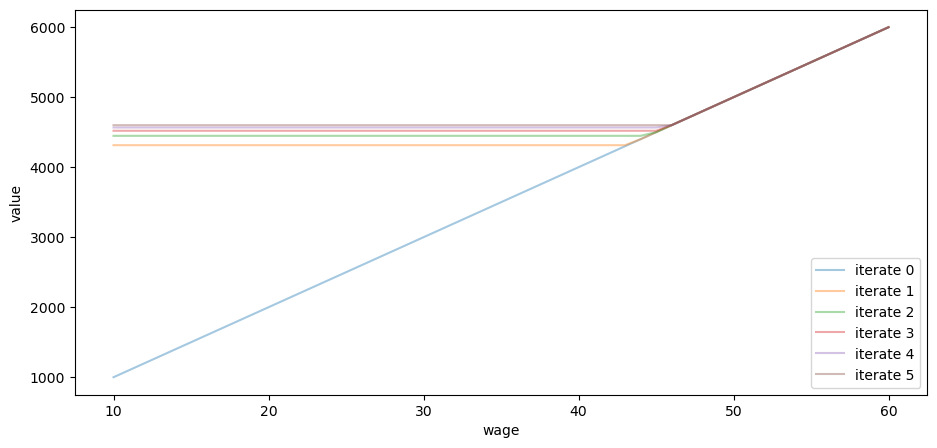

In [9]:
mcm = McCallModel()

fig, ax = plt.subplots()
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

You can see that convergence is occurring: successive iterates are getting closer together.

Here's a more serious iteration effort to compute the limit, which continues until measured deviation between successive iterates is below tol.

Once we obtain a good approximation to the limit, we will use it to calculate
the reservation wage.

We'll be using JIT compilation via Numba to turbocharge our loops.

In [10]:
@jit(nopython=True)
def compute_reservation_wage(mcm,
                             max_iter=500,
                             tol=1e-6):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute the value function == #

    n = len(w)
    v = w / (1 - β)          # initial guess
    v_next = np.empty_like(v)
    j = 0
    error = tol + 1
    while j < max_iter and error > tol:

        for j in range(n):
            v_next[j] = np.max(mcm.state_action_values(j, v))

        error = np.max(np.abs(v_next - v))
        j += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * q))

The next line computes the reservation wage at  default parameters

In [11]:
compute_reservation_wage(mcm)

47.316499710024964

### Comparative Statics

Now that we know how to compute the reservation wage, let's see how it varies with
parameters.

In particular, let's look at what happens when we change $\beta$ and
$c$.

In [12]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcm = McCallModel(c=c, β=β)
        R[i, j] = compute_reservation_wage(mcm)

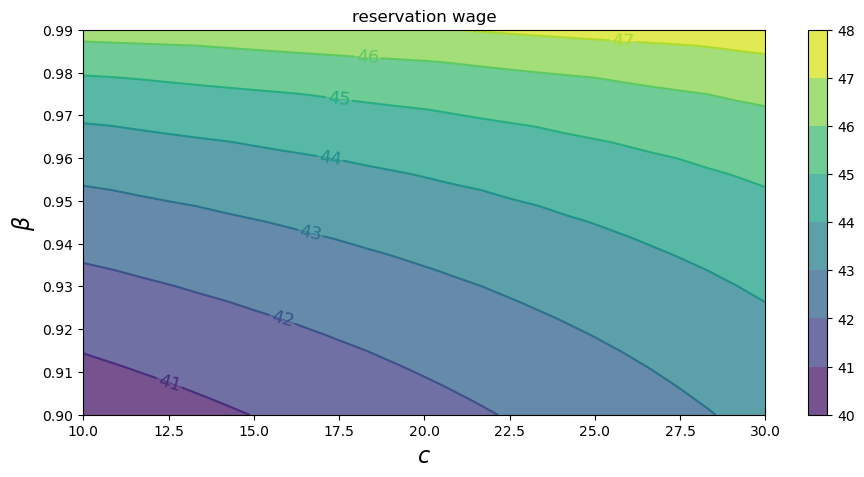

In [13]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

As expected, the reservation wage increases both with patience and with
unemployment compensation.

(mm_op2)=
## Computing an Optimal Policy: Take 2

The approach to dynamic programming just described is standard and
broadly applicable.

But for our McCall search model there's also an easier way that  circumvents the
need to compute the value function.

Let $h$ denote the continuation value:

```{math}
:label: j1

h
= c + \beta
    \sum_{s'} v^*(s') q (s')
\quad
```

The Bellman equation can now be written as

$$
v^*(s')
= \max \left\{ \frac{w(s')}{1 - \beta}, \, h \right\}
$$

Substituting this last equation into {eq}`j1` gives

```{math}
:label: j2

h
= c + \beta
    \sum_{s' \in \mathbb S}
    \max \left\{
        \frac{w(s')}{1 - \beta}, h
    \right\}  q (s')
\quad
```

This is a nonlinear equation that we can solve for $h$.

As before, we will use successive approximations:

Step 1: pick an initial guess $h$.

Step 2: compute the update $h'$ via

```{math}
:label: j3

h'
= c + \beta
    \sum_{s' \in \mathbb S}
    \max \left\{
        \frac{w(s')}{1 - \beta}, h
    \right\}  q (s')
\quad
```

Step 3: calculate the deviation $|h - h'|$.

Step 4: if the deviation is larger than some fixed tolerance, set $h = h'$ and go to step 2, else return $h$.

One can again use the Banach contraction mapping theorem to show that this process always converges.

The big difference here, however, is that we're iterating on a scalar $h$, rather than an $n$-vector, $v(i), i = 1, \ldots, n$.

Here's an implementation:

In [14]:
@jit(nopython=True)
def compute_reservation_wage_two(mcm,
                                 max_iter=500,
                                 tol=1e-5):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute h == #

    h = np.sum(w * q) / (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        s = np.maximum(w / (1 - β), h)
        h_next = c + β * np.sum(s * q)

        error = np.abs(h_next - h)
        i += 1

        h = h_next

    # == Now compute the reservation wage == #

    return (1 - β) * h

You can use this code to solve the exercise below.

## Exercises

```{exercise}
:label: mm_ex1

Compute the average duration of unemployment when $\beta=0.99$ and
$c$ takes the following values

> `c_vals = np.linspace(10, 40, 25)`

That is, start the agent off as unemployed, compute their reservation wage
given the parameters, and then simulate to see how long it takes to accept.

Repeat a large number of times and take the average.

Plot mean unemployment duration as a function of $c$ in `c_vals`.
```

```{solution-start} mm_ex1
:class: dropdown
```

Here's one solution

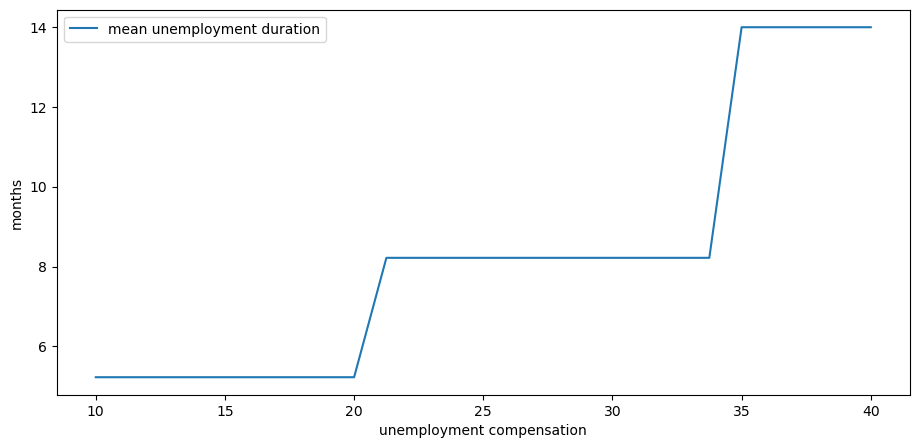

In [15]:
cdf = np.cumsum(q_default)

@jit(nopython=True)
def compute_stopping_time(w_bar, seed=1234):

    np.random.seed(seed)
    t = 1
    while True:
        # Generate a wage draw
        w = w_default[qe.random.draw(cdf)]
        # Stop when the draw is above the reservation wage
        if w >= w_bar:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

@jit(nopython=True)
def compute_mean_stopping_time(w_bar, num_reps=100000):
    obs = np.empty(num_reps)
    for i in range(num_reps):
        obs[i] = compute_stopping_time(w_bar, seed=i)
    return obs.mean()

c_vals = np.linspace(10, 40, 25)
stop_times = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c)
    w_bar = compute_reservation_wage_two(mcm)
    stop_times[i] = compute_mean_stopping_time(w_bar)

fig, ax = plt.subplots()

ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()

```{solution-end}
```

```{exercise-start}
:label: mm_ex2
```

The purpose of this exercise is to show how to replace the discrete wage
offer distribution used above with a continuous distribution.

This is a significant topic because many convenient distributions are
continuous (i.e., have a density).

Fortunately, the theory changes little in our simple model.

Recall that $h$ in {eq}`j1` denotes the value of not accepting a job in this period but
then behaving optimally in all subsequent periods:

To shift to a continuous offer distribution, we can replace {eq}`j1` by

```{math}
:label: j1c

h
= c + \beta
    \int v^*(s') q (s') ds'.
\quad
```

Equation {eq}`j2` becomes

```{math}
:label: j2c

h
= c + \beta
    \int
    \max \left\{
        \frac{w(s')}{1 - \beta}, h
    \right\}  q (s') d s'
\quad
```

The aim is to solve this nonlinear equation by iteration, and from it obtain
the reservation wage.

Try to carry this out, setting

* the state sequence $\{ s_t \}$ to be IID and standard normal and
* the wage function to be $w(s) = \exp(\mu + \sigma s)$.

You will need to implement a new version of the `McCallModel` class that
assumes a lognormal wage distribution.

Calculate the integral by Monte Carlo, by averaging over a large number of wage draws.

For default parameters, use `c=25, β=0.99, σ=0.5, μ=2.5`.

Once your code is working, investigate how the reservation wage changes with $c$ and $\beta$.

```{exercise-end}
```

```{solution-start} mm_ex2
:class: dropdown
```

Here is one solution:

In [16]:
mccall_data_continuous = [
    ('c', float64),          # unemployment compensation
    ('β', float64),          # discount factor
    ('σ', float64),          # scale parameter in lognormal distribution
    ('μ', float64),          # location parameter in lognormal distribution
    ('w_draws', float64[:])  # draws of wages for Monte Carlo
]

@jitclass(mccall_data_continuous)
class McCallModelContinuous:

    def __init__(self, c=25, β=0.99, σ=0.5, μ=2.5, mc_size=1000):

        self.c, self.β, self.σ, self.μ = c, β, σ, μ

        # Draw and store shocks
        np.random.seed(1234)
        s = np.random.randn(mc_size)
        self.w_draws = np.exp(μ+ σ * s)


@jit(nopython=True)
def compute_reservation_wage_continuous(mcmc, max_iter=500, tol=1e-5):

    c, β, σ, μ, w_draws = mcmc.c, mcmc.β, mcmc.σ, mcmc.μ, mcmc.w_draws

    h = np.mean(w_draws) / (1 - β)  # initial guess
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        integral = np.mean(np.maximum(w_draws / (1 - β), h))
        h_next = c + β * integral

        error = np.abs(h_next - h)
        i += 1

        h = h_next

    # == Now compute the reservation wage == #

    return (1 - β) * h

Now we investigate how the reservation wage changes with $c$ and
$\beta$.

We will do this using a contour plot.

In [17]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcmc = McCallModelContinuous(c=c, β=β)
        R[i, j] = compute_reservation_wage_continuous(mcmc)

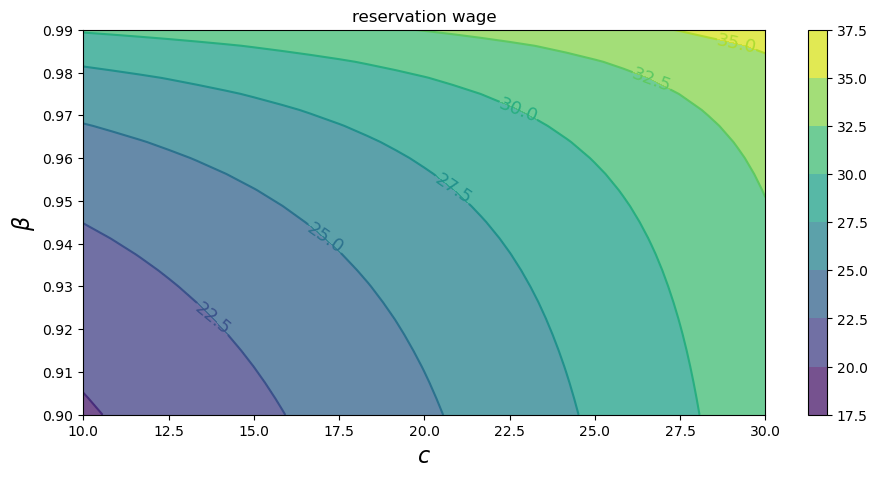

In [18]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

```{solution-end}
```